# Principle Component Analysis (PCA) of dPHA maps

### Hans Moritz Günther (CXC/MIT)
### last updated: 2020-01-22

> **Summary**
> 
> Up to now (end of 2020), the ACIS gain has been calibrated using the external calibraiton source (ECS). 
> The ECS consists of a radioactive material that emits X-ray lines at well-known energies over a low background
> and is places on the ACIS housing such that all chips are fully illuminated.
> Since ECS decays over time, counts rates are becoming too low to continue as we did in the past. Instead
> astrophysical calibration sources will be needed, which do not fill the field of view. 
> From the data in the past 20 years, we know that the ACIS gain depends on the chip position and evolves with time.
> Both dependencies are not random, but follow a spatial and temporal pattern.
> Here, I determine the dominant spatial components. I find that, given the noise levels we have today, all dPHA maps
> can be sufficiently described by just a few (often only one) spatial component. I conclude that it is not necessary
> to expose the entire chip to a calibration source, illuminating a small area is enough.
> 
> Thanks to Nick for providing the input data and for helping me to get started!

In the past, the dPHA maps for each chip have been constructed by fitting a number of regions (256 regions of 32 * 128 pixels each) independently. One can see that the maps show consistent large scale structure. As the calibration source ages, fitting 256 regions independently is not be possibly any longer; instead  we could try to parameterize the spatial dependence and fit just a few parameters which can be done with more noisy data.

The basic idea is to use PCA (Principle Component Analysis). Each observed dPHA image can be thought of as a vector with 256 features. PCA will find new bases vectors in 256 dimensional space choosing the bases vectors (=image components) such that most of the variability between images can be described by just a few components.

This document is a jupiter notebook for an analysis in Python, using common scientific packages. If you are looking at the html version, you can use the button below to toggle the display of the Python code on/off. The code is somewhat commented, but not to the level of a "production pipeline".

In the analysis, it will be apprarent that the chips fall into three groups, where the BI chips behave similarly, I0 and I2 do, and the remaining FI chips form the last group. Most of the plots are thus done for just one or a few chips (e.g. I0, I1, and S3).

The gain also depends strongly on temerature, but that is beyond the scope of this study, all data here is from nominal cold observations.

## Overview

- Gain calibrated with ECS data, but ECS counts rates are decaying
- so far: fit 256 independent tiles (32 * 128 pixels each) independently
- now: use PCA to determine dominant components, fit top 5 components to noisy data

In [14]:
from IPython.display import HTML
HTML('''<script>
code_show=true;
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 $('div.prompt').hide();
 } else {
 $('div.input').show();
 $('div.prompt').show();
}
 code_show = !code_show
}
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the display of raw code."></form>''')


In [15]:
import os
from glob import glob
import numpy as np
from scipy import stats
from astropy.io import fits
from astropy.table import Table
from astropy.time import Time

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

from fit_tile import reg2im1024

%matplotlib inline

In [16]:
import holoviews as hv
from holoviews import opts
hv.extension('bokeh', 'matplotlib', logo=False)
opts.defaults(
    opts.Image(cmap='viridis', width=400, height=400),
 )

In [17]:
dirlist = glob('ecs_pha_fits/*')
dirlist.remove('ecs_pha_fits/README.data')

In [18]:
# Check that all files have the same 32 * 128 tiling.
tab1 = Table.read('ecs_pha_fits/e1/i3_noTG.lloc', format='ascii', header_start=1)
for d in dirlist:
    tab = Table.read(f'{d}/i3_noTG.lloc', format='ascii', header_start=1)
    for col in ['xlo', 'xhi', 'ylo', 'yhi']:
        assert np.all(tab1[col] == tab[col])

In [19]:
single_epochs = Table.read('ecs_pha_fits/README.data', format='ascii', names=['e', 'date'])
single_epochs['date'] = Time(single_epochs['date'])

In [20]:
e_list = []
time_list = []
e_num = []
for d in dirlist:
    e_list.append(os.path.basename(d))
    e_n = os.path.basename(d).split('e')[1:]
    if len(e_n) == 1:
        time_list.append(single_epochs['date'][single_epochs['e'] == e_n[0]][0])
    elif len(e_n) == 2:
        # Two epoch names, so take the mean.
        # Unfortunately, np.mean does not work, so implementation is a little clunky.
        d0 = single_epochs['date'][single_epochs['e'] == e_n[0]]
        d1 = single_epochs['date'][single_epochs['e'] == e_n[1]]
        time_list.append((d0 + (d1 - d0) / 2)[0])
    else:
        raise ValueError('need one or two epoch numbers in dir name')

epochs = Table(data=(e_list, Time(time_list)), names=['e', 'date'])
epochs.sort('date')

In [21]:
elements = ['Al', 'Ti', 'Mn']
# From http://hyperphysics.phy-astr.gsu.edu/hbase/Tables/kxray.html
# I manually picked a round number in the middle between Ka1 and Ka2

Ka1_energies = np.array([1486.296, 4504.92, 5887.6859])
Ka2_energies = np.array([1486.708, 4510.8991, 5898.8010])

# Ka1:Ka2 is very close to 2:1 for all elements
# https://en.wikipedia.org/wiki/Siegbahn_notation#K-alpha
# so we use that to average
line_energies = (2 * Ka1_energies + Ka2_energies) / 3

## Data shape and format

In this section I read the data into arrays and run PCA on the array for each chip. Occasionally, there a few points of missing data. This happens more frequently in recent observations, because the calibration source is weaker now. For numerical stability, I smooth over those and fill them with the mean of the values of the surrounding pixels.

In [22]:
def read_one_epoch(filename, epochs, i):
    data = np.zeros((3, len(tab1)))
    err = np.zeros_like(data)
    row = epochs[i]
    tab = Table.read('ecs_pha_fits/{}/{}'.format(row['e'], filename), format='ascii', header_start=1)
    for j, elem in enumerate(['Al', 'Ti', 'Mn']):
        data[j, :] = tab[elem]
        err[j, :] = tab[f'{elem}err']
    return data, err
  

def read_all_epochs(filename):
    data = np.zeros((len(epochs), 3, len(tab1)))
    err = np.zeros_like(data)
    for i, row in enumerate(epochs):
        d, e = read_one_epoch(filename, epochs, i)
        data[i, :, :] = d
        err[i, :, :] = e
    return data, err

In [23]:
from astropy.convolution import interpolate_replace_nans
from astropy.convolution import Box2DKernel
kernel = Box2DKernel(3)

def fill_missing_values(arr, err):
    ind = arr == 9999
    arr[ind] = np.nan
    err[ind] = np.nan
    print('Filling {} missing values'.format(ind.sum()))
    for i, j, k in zip(*ind.nonzero()):    
        im = arr[i, j, :].reshape((32, 8))
        result = interpolate_replace_nans(im, kernel, boundary='extend')
        arr[i, j, :] = result.flatten()
    return arr, err

In [24]:
def do_pca(arr, *args, **kwargs):
    '''Perform PCA and scale and shift projected values
    
    Parameters
    ----------
    arr : np.array of shape (n_epochs, n_lines, n_features)
    
    Returns
    -------
    pca : `sklearn.decomposition.PCA`
        instance of PCA
    projected : np.array of shape (n_epochs, n_lines, n_pca_components)
        array of projected number in the space of the PCA components.
    '''
    pca = PCA(*args, **kwargs)
    projected = np.ascontiguousarray(pca.fit_transform(arr.reshape([-1, 256])))
    projected3 = projected.reshape((-1, 3, projected.shape[-1]))
    return pca, projected3

In [25]:
fi_chips = ['i0_noTG', 'i1_noTG', 'i2_noTG', 'i3_noTG', 's0_noTG', 's2_noTG', 's4_noTG', 's5_noTG']
bi_chips = ['s1_noTG','s1_noTGnoCTI', 's3_noTG', 's3_noTGnoCTI']
examples = ['i0_noTG', 'i1_noTG', 's3_noTG']  # subset used for smaller plots

In [26]:
dat = {}
for c in fi_chips + bi_chips:
    print(f'reading {c}')
    arr, err = read_all_epochs(f'{c}.lloc')
    arr, err = fill_missing_values(arr, err)
    dat[c] = {'PHA': arr, 'PHA_err': err,
              'dPHA0': arr - arr[0, ...],
             }
    

reading i0_noTG
Filling 19 missing values
reading i1_noTG
Filling 7 missing values
reading i2_noTG
Filling 16 missing values
reading i3_noTG
Filling 5 missing values
reading s0_noTG
Filling 260 missing values
reading s2_noTG
Filling 17 missing values
reading s4_noTG
Filling 92 missing values
reading s5_noTG
Filling 65 missing values
reading s1_noTG
Filling 8 missing values
reading s1_noTGnoCTI
Filling 13 missing values
reading s3_noTG
Filling 0 missing values
reading s3_noTGnoCTI
Filling 0 missing values


### What is the baseline?

When looking at the "gain correction" in epock $i$, we have in the past looked the change relative to the gain observed in the first epoch ($\mathrm{dPHA}_i = \mathrm{PHA}_1 - \mathrm{PHA}_i$). That way, we get a nice flat distribution in the beginning and then see the gain change develop over time. For display purposes, this is actually very useful, because the gain changes evolve slowly and the dPHA is small compared to the node-to-node differences in the gain that are aalready present in the first epoch. On the other hand, this way of looking at it obscures that fast that the gain changes are actually relatively small.

One additional complication of this approach is that the (mostly) linear dependence of the energy on the gain is no longer part of the data - in fact that is the whole reason for doing this. However, as I will show towards the end, it can be very beneficial to study the energy dependence of individual components of the gain coorrection. In particular,  fitting the energy dependence of the gain in principle allows us to use the decomponsition I will do below at any energy, which becomes important when we try to apply it to Cas A data. While I have not fully solved this problem yet, I will thus in general treat PHA values below, not $\mathrm{dPHA}_i$ except for a few plots.

### How does the data look?

After reading all the data and filling missing values the resulting image might look like the following (here epoch 50 for the I3 chip in the Ti line).

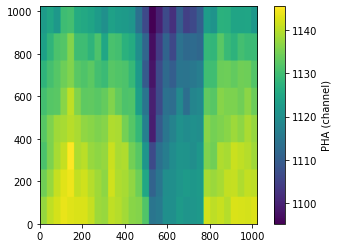

In [27]:
tab = Table.read('ecs_pha_fits/e50/i3_noTG.lloc', format='ascii', header_start=1)
plt.imshow(reg2im1024(tab, 'Ti').T, origin='lower')
out = plt.colorbar()
out.set_label('PHA (channel)')

Im my plot, the (0,0) point is at the bottom left, but that's obviously just a choice for visualization. Since each area on the chip is 32 * 128 pixels large, I can make a more compressed version of the same data where I represent each region by just one pixel. This is the same data but epoch 1 is already subtracted to present the dPHA value instead of the PHA. Note how in the plot below the third node no longer stands out because the node-to-node differences are mostly constant in time and are thus not visible relative to the first epoch.

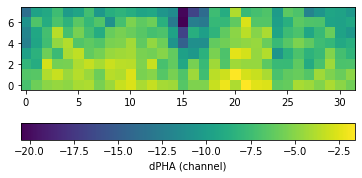

In [28]:
plt.imshow(dat['i3_noTG']['dPHA0'][49, 0, :].reshape(32, 8).T, origin='lower')
out = plt.colorbar(orientation='horizontal')
out.set_label('dPHA (channel)')

In [29]:
ylabels = np.arange(1024).reshape((8, -1)).mean(axis=1)
xlabels = np.arange(1024).reshape((32, -1)).mean(axis=1)

ds = hv.Dataset((ylabels, xlabels, elements, epochs['date'].jyear, dat['s3_noTG']['dPHA0'].reshape(-1, 3, 32, 8)),
                ['y', 'x', 'Energy', 'Time'], 'dPHA0')

ds.to(hv.Image, ['x', 'y'], 'dPHA0', ['Time', 'Energy']).opts(colorbar=True)

:HoloMap   [Time,Energy]
   :Image   [x,y]   (dPHA0)

Here is another visualization. This one is interactive, and one can see for one CCD (here S3) that the time evolution of the dPHA values is clearly not random. It evolves in a predictable manner in time and it is also correlated between different energies. Again, this plot shows the dPHA, where the first epoch is subtracted. This way, the color scale does not have to span a large range, making it easier to see the spatial structure of the dPHA evolve in time.

This plot shows the S3 chip (simply because it would make the website very large if data for all chips was stored for a visualization like this), but other chips look similar.

## PCA results

Principal Component analysis (PCA) is a well known mathematical concept and a description  [can be found elsewhere](https://en.wikipedia.org/wiki/Principal_component_analysis); I'm using the implementation from [scikit-learn](https://scikit-learn.org/stable/modules/decomposition.html#pca). In short, we can look at the 256 regions in each image as a vector in 256-d space. PCA finds a new set of basis vectors and orders them such that the first vector in the list describes the direction with the largest variance between the input data points, the second vector the direction with the second most variance and so on. The new basis vectors always form an orthogonal basis (i.e. the PCA components are independent) and the process of calculating them is determinisitic. (There are alternative implementations of PCA that make use of approximations to speed up the computation, but that is not a concern for the size of this dataset.) However, the new basis may not be complete. If only 215 datapoints are put into the PCA, the new basis will only have 215 vectors and thus not span the entire 256 dimensional space.
PCA can be used as a tool for dimensionality reduction and noise reduction. A simple example is a set of datapoints in 3D space that all fall onto a single plane with just some noise above and below the plane. In that case, the PCA will return two vectors that span up the plane and one that's perpendicular to it. The importance of this last component will be small. We can then decide to discard this component and only retain the remaining two, effectively forcing all points on the plane, which reduced the noise in one direction. At the end, those new noise-reduced points can be projected back into the original 3D space.

Similarly, I use PCA here to identify spatial components of the gain that vary together. For example, if the gain for the four nodes on the chip evolves with time, but in a different way, then we would get four components, one for each node. The images of those components would show the node in question and have a value of "0" for the others. 

A few technicalities for the PCA that are worth writing down here: The mean of the daa is subtracted before running PCA and the sign of the new bases vectors is arbitrary.

This description of a 256d vector discards the 2D structure of the image, no relation between individual components is assumed in the PCA. As we will see below, folding the 256-d vectors back into an 32 * 8 image will result in sensible 2D images. This is a useful sanity check. 

For each chip, we run one PCA on data from all epochs and all three lines (Al, Ti, Mn) that we can measure from the ECS. The PCA returns components that describe most of the observed variance. For each point in time (epoch) and line (Al, Ti, Mn), we get a set of factors. Time evolution in the dPHA thus is described by the time series of these coefficients.

In [30]:
def do_pca_with_0(arr, *args, **kwargs):
    '''Perform PCA and scale and shift projected values
    
    This includes the 0 point into the input array to ensure that 
    everything can be expressed relative to PHA=0.
    
    Parameters
    ----------
    arr : np.array of shape (n_epochs, n_lines, n_features)
    
    Returns
    -------
    pca : `sklearn.decomposition.PCA`
        instance of PCA
    projected : np.array of shape (n_epochs, n_lines, n_pca_components)
        array of projected number in the space of the PCA components.
    '''
    arr = np.vstack([np.zeros((1, arr.shape[-1])), 
                     arr.reshape([-1, 256])])

    pca = PCA(*args, **kwargs)
    projected = np.ascontiguousarray(pca.fit_transform(arr))
    projected3 = projected[1:, :].reshape((-1, 3, projected.shape[-1]))
    projected_0 = projected[0, :]
    return pca, projected3, projected_0

In [31]:
for v in dat.values():
    pca, proj, proj0 = do_pca_with_0(v['PHA'], svd_solver='full')
    v['fullpca'] = pca
    v['fullproj'] = proj
    # PCA subtracts the mean, so we now subtract that
    # to get coefficients measured from 0 instead of from mean.
    v['fullproj0'] = proj - proj0

### How do the spatial components look?

<a id='PCA_components_image'></a>

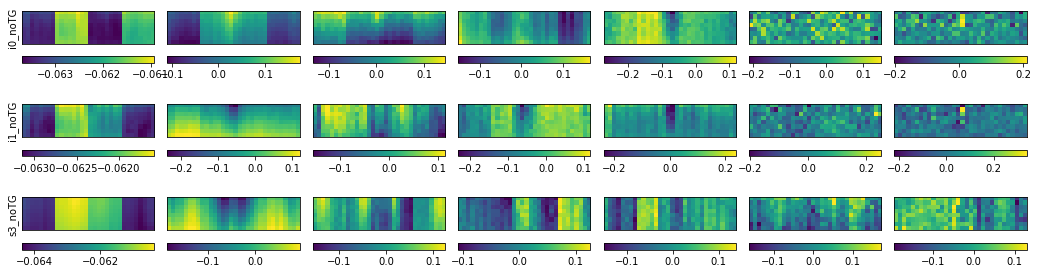

In [32]:
fig, axes = plt.subplots(ncols=7, nrows=len(examples), figsize=(18, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
for i, k in enumerate(examples):
    pca = dat[k]['fullpca']
    for j in range(7):
        out = axes[i, j].imshow(pca.components_[j].reshape(32, 8).T, origin='lower')
        plt.colorbar(out, ax=axes[i, j], orientation='horizontal')
    axes[i, 0].set_ylabel(k)

Top seven most important PCA components (left to right) for different chips (rows). Some similarities are seen between chips. The most important component (left column) has a very small range of values, the difference between the min and max in the image of this component is only of order 0.02, while it is 0.2 to 0.5 for the other components. That means that all regions on hte chip bahave very similar when this component changes. We will see later that this component is essentially the linear scaling between energy and PHA. That proportionality differs slightly between nodes and ever more slightly wihtin a node. The next component all have structure mostly along columns, with consistent changes from the top to the bottom of the chip (recall that the sign is arbitrary here, since only the product of the scaling for this component $x_i$ and the 256-d vector of component values $C_i$ matter ($x_i * C_i = -x_i * -C_i$).)

In most cases, spatial structure is clearly evident in these components, indication that they indeed have some physical relevance (Remember that the PCA by itself does not know anything about the 2D structure. Each "image" is simply a 1D vector of 256 numbers.)

For comparison, the plot below shows some components of lesser importance (components 10 to 17 ), which look dominated by noise although some feature features that are spatially consistent (e.g. the step between the third and forth node in the top left image) are still present.

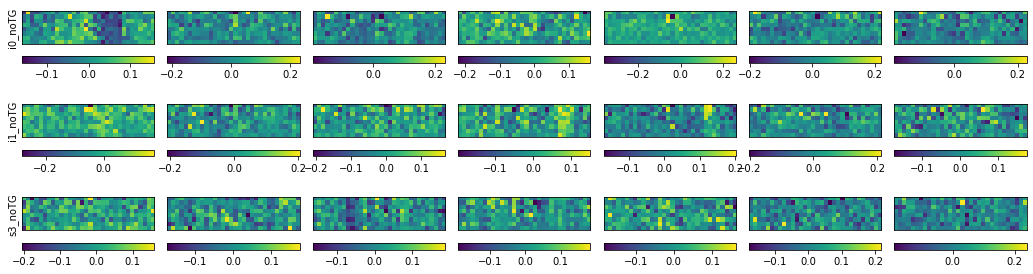

In [33]:
fig, axes = plt.subplots(ncols=7, nrows=len(examples), figsize=(18, 5),
                         subplot_kw={'xticks':[], 'yticks':[]},
                         gridspec_kw=dict(hspace=0.1, wspace=0.1))
    
for i, k in enumerate(examples):
    pca = dat[k]['fullpca']
    for j in range(10, 17):
        out = axes[i, j - 10].imshow(pca.components_[j].reshape(32, 8).T, origin='lower')
        plt.colorbar(out, ax=axes[i, j - 10], orientation='horizontal')
    axes[i, 0].set_ylabel(k)

### Explained variance and time evolution of scaling factors

The PCA orders components by importance, such that the first component explained the most of the data variance. Thus, one of the first things to look at is how many components are needed to describe, e.g. 95% of the observed variance. Given that the observations do contain noise, we are not looking for a perfect description of the input data by PCA components. Instead, we need to determine which components are physical and which just fit the noise.

Also, we want to look at the time dependence of the scaling factors for the most important components.

In [34]:
def plot_explained_var_ratio(ax, arr):
    for sl, label in zip([0, 1, 2, slice(4)], ['Al', 'Ti', 'Mn', 'All']):
        pca = PCA()
        projected = np.ascontiguousarray(pca.fit_transform(arr[:, sl, :].reshape([-1, 256])))
        ax.plot(np.arange(pca.n_components_) + 1, # to make x axis start as 1
                np.cumsum(pca.explained_variance_ratio_), label=label)
    ax.set_xlabel('number of components')
    ax.set_ylabel('cumulative explained variance')
    ax.legend()
    ax.set_xlim(0, 30) 
    ax.set_ylim(None, 1)

In [35]:
lineprops = {'Al': {'lw': 5, 'alpha': .5},
             'Mn': {'ls': ':'},
             'Ti': {}}
# set color cycle for absolute number
max_comp=8
compcolors = plt.cm.nipy_spectral(np.linspace(0, 1, max_comp))

In [36]:
def plot_overview(arr, err, proj):
    fig, axes = plt.subplots(ncols=2, nrows=2, figsize=(10, 10))

    plot_explained_var_ratio(axes[0, 0], arr - arr[0, :, :])

    axes[1, 0].axvspan(2015, 2020.5, facecolor='0.5', alpha=0.5)
    axes[1, 0].plot(epochs['date'].jyear, np.nanmean(err, axis=(1,2)))
    axes[1, 0].set_ylabel('Average error [channels]')
    # All PCA components
    for j in range(7, -1, -1):
        for i, elem in enumerate(['Al', 'Ti', 'Mn']):
            out = axes[0, 1].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j], 
                              label=elem if j==0 else '__no_legend__')
    axes[0, 1].legend()
    axes[0, 1].set_title('PCA components')
    axes[0, 1].set_ylabel('Scaling of component')
    
    # All PCA components except for the first two
    for j in range(7, 1, -1):
        for i, elem in enumerate(['Al', 'Ti', 'Mn']):
            out = axes[1, 1].plot(epochs['date'].jyear, proj[:, i, j], **lineprops[elem], color=compcolors[j],
                         label=f'{j + 1}' if i == 0 else '__no_legend__')
    axes[1, 1].legend(title='PCA comp', ncol=2)
    axes[1, 1].set_title('PCA component 2-7')
    axes[1, 1].set_ylabel('Scaling of component')
    
    return fig, axes

In the following, I show a set of four plots for each chip. (BI chips are shown twice, with and without CTI.).

*top left:* Cumulative explained variance depending on the number of components used in the PCA of the dPHA values. This is done four times: Once for Al, Ti, and Mn each (i.e. with 75 input epochs) and once using all the data for one chip at the same time ($3 * 75 = 225$ input vectors). The more information is available, the better the PCA components will be. Since the dPHA maps for Al, Ti, and Mn are clearly similar, it makes sense to describe them with the same spatial components. As an example, for the I0 chip, 95% of the variance in the Mn data can be explained with just one spatial component. The more components are used, the more of the variance will be explained. However, given that the input data contains noise, there is no need to explain everything, we would just be fitting the noise. Instead, we are looking for the most important components aonly. In all chips, Al needs more components, but (not shown here directly) it's also the most noisy data. Note that for the *top left plot only*, we perform PCA on the dPHA values, not the raw PHA values. For the PCA of the PCA values, the largest difference between the data of Al, Ti, and, Mn is that these lines are taken at different energies. A first component of the PCA takes care of this linear dependence and thus explains $>0.9999$ of the variance. However, we need to decide how many component to look at beyond the simple proportionality with energy and thus it is more instructive to look at a PCA of the dPHA values with most of the energy dependenace taken out. 

*bottom left:* Average error in the dPHA maps over time. As the calibration source decays, the average error increases. That means that there will be more noise in the PCA decompositions of data taken more recently. The grey area shows the time when Nick combined two epochs for fitting.

*right column:* Scaling factor for the first few PCA components over time. Different colors are for different compoments, different line styles for Al, Ti, and Mn. For example, the Ti image of a particular epoch can be written as scaling of component 1 multiplied by the spatial component 1, plus the scaling of component 2 multiplied by component 2 and so on. 

*Top right:* Scaling of the first few PCA components. The first component describes the (almost) linear relation between PHA and energy and its scale is so large that the remaining component all fall on top of each other. The first component is not constant with time, but small variability is hard to see here. In the next section, we plot the first component for just the Ti line so that the y-scale can be chosen to display temperal evolution better.


*Bottom right:* The first (the strongest) component is much more important than the next few, so this is the same plot without the first component.
The scaling of the the PCA components for Al, Ti, and Mn behaves typically very similarly. This is explored in more detail below. These plots also give a first hint which components are physical and which start to describe the noise. Components that describe physcial processes on the chip should have trends in time, because the dPHA values are correlated from one epoch to the next. On the other hand, components that just describe the noise pattern fluctuate around 0 and start to fluctuate more at later times when the noise in the data increases, e.g. components 6 or 7 for the I0 chip.

<a id='explained_variance'></a>

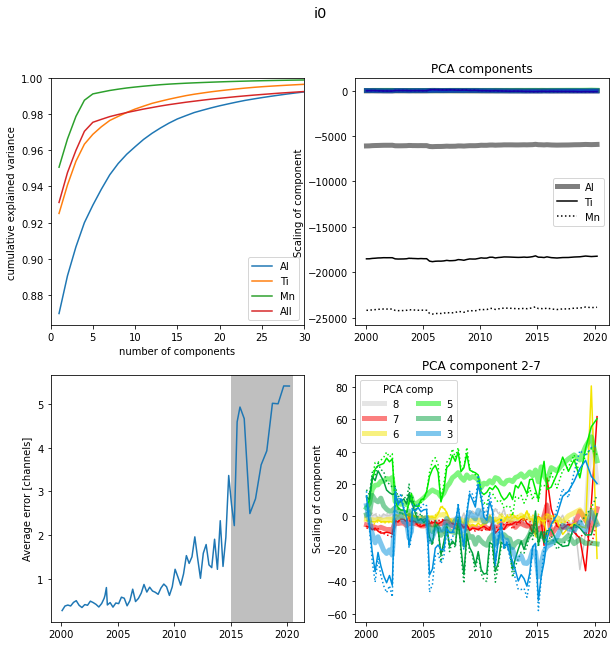

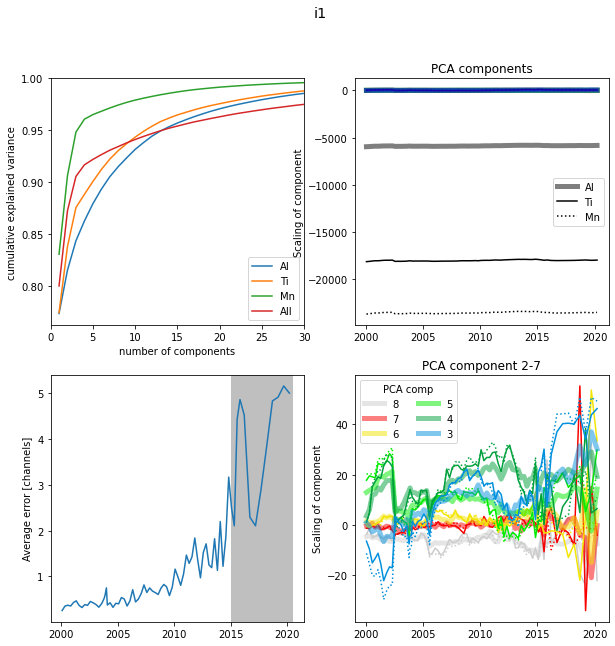

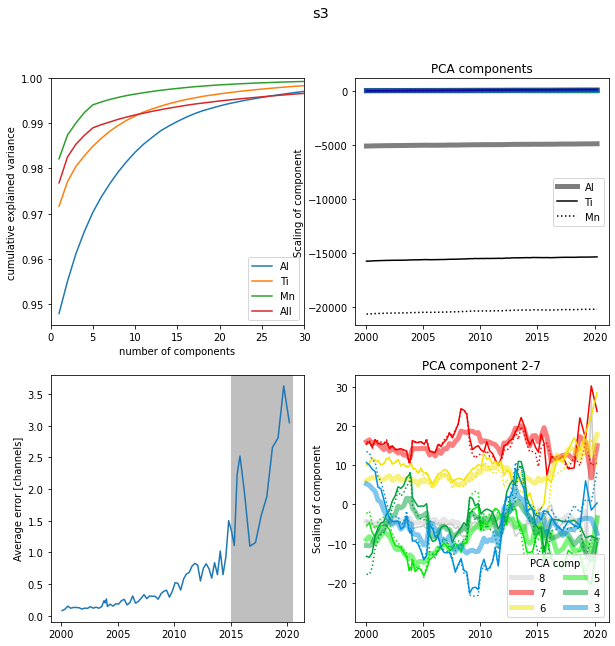

In [37]:
for v in examples:
    fig, axes = plot_overview(dat[v]['PHA'], dat[v]['PHA_err'], dat[v]['fullproj0'])
    fig.suptitle(v.replace('_noTG', ''), fontsize='x-large')

The three chips shown here are representative for all ACIS chips.

<a id='comparing_chips'></a>
### Comparing chips
Let's compare chips a little more. To make everything fit on one plot, I'm going to show just the scaling of the strongest PCA component for all chips.

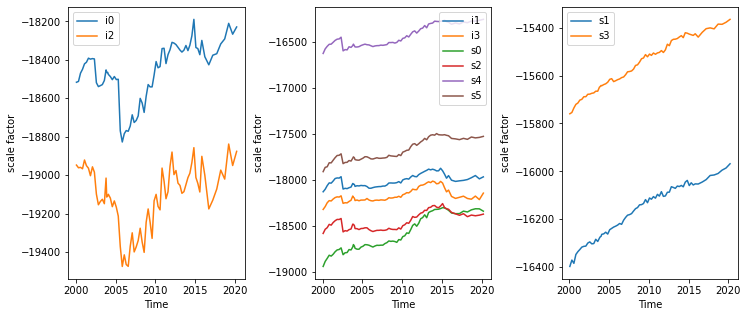

In [38]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 5))
for i, chips in enumerate([['i0_noTG', 'i2_noTG'], 
                           ['i1_noTG', 'i3_noTG', 's0_noTG', 's2_noTG', 's4_noTG', 's5_noTG'],
                           ['s1_noTG', 's3_noTG']]):
    for k in chips:
        axes[i].plot(epochs['date'].jyear, dat[k]['fullproj0'][:, 1, 0], label=k.replace('_noTG', ''))
        axes[i].legend()

for ax in axes:
    ax.set_xlabel('Time')
    ax.set_ylabel('scale factor')
fig.subplots_adjust(wspace=.4)

Scale factor for the strongest component in the PCA for Ti. Chips are empirically sorted in groups with different temporal behaviour.

This plots shows that chips fall into essentially three groups: For BI chips, the scale factor of the strongest component changes essentially linear with time (with a small offset in the first two years). The FI chips shows two different behaviours: While I2 developed an offset from I0 in the beginning, both chips have been developing in parallel since about 2003. The remaining chips (I1, I3, S0, S2, S4, S5), from another group with very similar time evolution. In all cases, the scale factor moves up quickly between 2000 and 2003, when a sudden jump down occurs that bring some of the chips back down to 0. (Is there a know reason, e.g. change in temperature of charge?) After that, this group develops largely in parallel, with the same offset. Only in recent years (after 2015 or so) do the scale factors diverge more.

## Which PCA components are significant?

The plots above show that the noise increases significantly over time (bottom left plot for each chip). The bottom right plot shows the scaling factor which the PCA components contribute to the image over time. In all cases, the first few components are important, and they are important over the full time range, and there is significant coherent structure. In contrast, the higher components (e.g. 6,7,8 for I0) only turn up with a significant contribution in the last year or so and fluctuate widely. That's indicating that these components are mostly fitting the noise. In the following we give three different lines of reasoning that only the first four or five PCA components matter. 

### Time dependance of scaling factors
Here, we plot the autocorrelation function for the time dependence for each component. Random noise is random in time and thus consecutive measurements are unrelated and the autocorrelation will drop close to 0 for time step 2. On the other hand, physical changes in the the chip or the read-out won't appear one day and return to a previous state the next, so we expect that the scaling factors for PCA components that are physcially relevant are correlated between different epochs.

In [39]:
def autocorr(x):
    result = np.correlate(x, x, mode='full')
    return result[result.size // 2:] / result.max()

In [40]:
def plot_autocorr(ax, proj, compcolors):
    for j in range(proj.shape[-1] - 1, -1, -1):
        ax.plot(autocorr(proj[:, j]), 
                color=compcolors[j] if j < compcolors.shape[0] else '0.5', 
                label=str(j + 1))
    ax.set_xlabel('Time steps')
    ax.set_ylabel('autocorrelation coefficient')

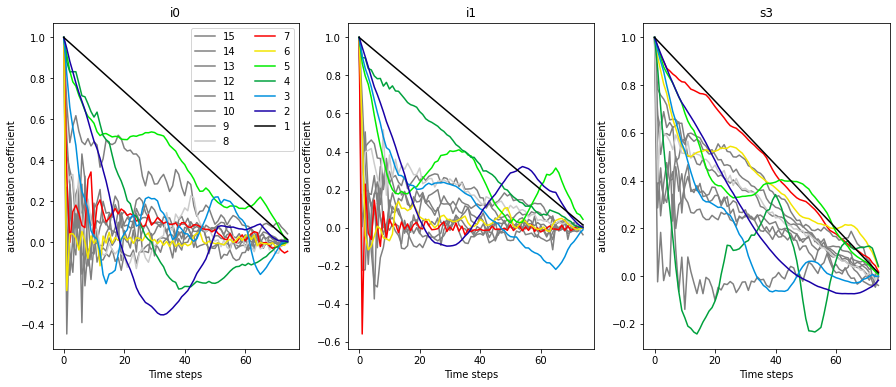

In [41]:
fig, axes = plt.subplots(ncols=3, figsize=(15, 6))
for i, c in enumerate(examples):
    plot_autocorr(axes[i], dat[c]['fullproj0'][:, 1, :15], compcolors)
    axes[i].set_title(c.replace('_noTG', ''))
out = axes[0].legend(ncol=2)

Plot of the autocorrelation functions for the first 15 components in Ti for I0, I2, and S3. Components 8-15 are all plotted in different shades of gray. 
For I0, components 1-5 are different from random noise, for I1 it's 1-5 and for S3 1-10 or so. Note that there are later components that have a long-time scale autocorrelation (e.g. one of the dark grey ones for I0). These components likely also describe physical properties of the CCD, but they are less important than some of the noise-only components (components are sorted by the oder of importance by the PCA) and, as we show in the next section are not consistent between different energies.

### Correlation between Al, Ti, and Mn lines

Similarly, we can correlate the curves for Al, Ti, and Mn. Random noise is uncorrelated, while physical components should affect the dPHA measure in each line. 

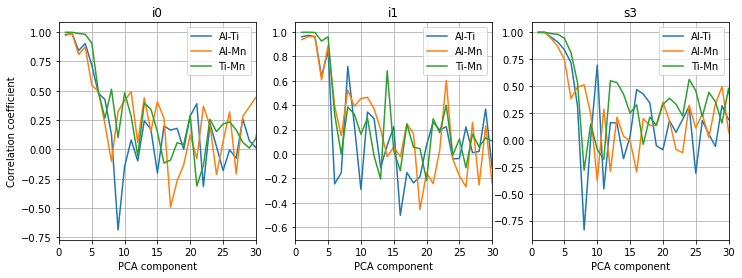

In [42]:
fig, axes = plt.subplots(ncols=3, figsize=(12, 4))
for i, c in enumerate(examples):
    proj = dat[c]['fullproj0']
    coeffs = np.zeros(proj.shape[1:])
    for j in range(proj.shape[-1]):
        coeffs[:, j] = np.corrcoef(proj[:, :, j].T)[([1, 2, 2], [0, 0, 1])]
    axes[i].plot(np.arange(1, proj.shape[-1] + 1), coeffs.T)
    axes[i].grid(True)
    axes[i].set_xlim(0, 30)
    axes[i].legend(['Al-Ti', 'Al-Mn', 'Ti-Mn'])
    axes[i].set_title(c.replace('_noTG', ''))
    axes[i].set_xlabel('PCA component')
out = axes[0].set_ylabel('Correlation coefficient')

For each PCA component, we have three time series of scaling factors, one from the Al, Ti, and Mn lines each. While the  dPHA values do have some energy dependence, physical changes in the chips should be seen in all three lines in some way and thus the three time series should be correlated. On the other hand, pure noise will be uncorrelated. The plots above show the correlation coefficients between the time series for Al, Ti, and Mn. In all cases, the first three or four components show strong correlations and after that the coefficients are compatible with random noise, compatible with the analysis above.

### Looking at the observed uncertainties with a $\chi^2$ test

In [43]:
def plot_chi2(dat, elem):
    fig, axes = plt.subplots(4, 3, figsize=(12, 12))
    axes = axes.flatten()

    for ax, k in zip(axes.flatten(), dat.keys()):
        for n in [1, 3, 5, 10, 50]:
            predict_n = dat[k]['fullproj0'][:, :, :n] @ dat[k]['fullpca'].components_[:n, :]
            redchi2 = np.nansum((dat[k]['PHA'] - predict_n)**2 / dat[k]['PHA_err']**2, axis=2) / dat[k]['PHA_err'].shape[-1]
            ax.semilogy(epochs['date'].jyear, redchi2[:, elements.index(elem)], label=str(n))
        ax.set_title(k.replace('_noTG', ''))
        ax.set_ylim(.1, 20)
        ax.set_ylabel('red. $\chi^2$')
        ax.legend(ncol=3)
    fig.subplots_adjust(hspace=.3, wspace=.3, top=.93)
    fig.suptitle(f'$\chi^2$ over time for fits to {elem} line with n spatial components', fontsize='x-large')
    return fig, axes

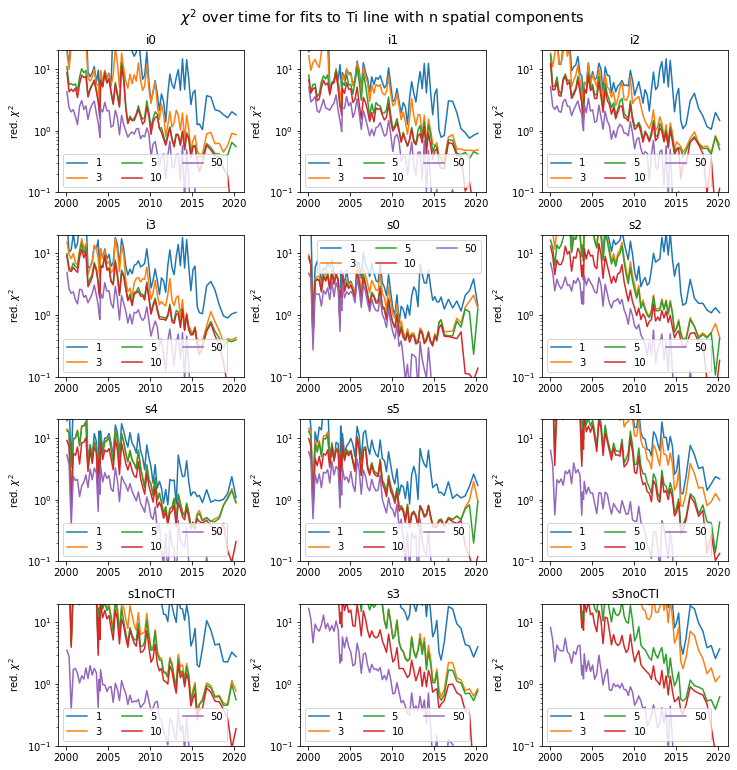

In [44]:
fig, axes = plot_chi2(dat, 'Ti')

This plot shows the reduced $\chi^2$ that a description with the first $n$ components of the PCA can give for each chip (here for the Ti line). In general, the $\chi^2$ drops with time for any chosen $n$. We already showed above that the measurement uncertainty increases with time, as the intensity of the calibration source decreases. In itself, that is not surprising. While the shapes of the curves are similar, the scale differs. For most cases, several dozen components are necessary to reach  $\chi^2$ around one for early times, in other words, each region on the detector actually evolves different. However, with decreasing signal, less and less of that can the measured reliably, and at later times, after 2015 or so, good fits can often be obtained with just one or two spatial components. In several chips, there is a noticable uptick in $\chi^2$ in 2019. I suspect that this is dues to new systematics becoming important that are not treated properly in this analysis, namely the count number becomes so low that for some regions a Gaussian error appoximation is not appropriate any longer. Plots for Al and Mn are not shown here, but look similar.

This analysis indicates that from 2010 on all chips can be described by just four or five compoments, which is compatible with the analysis in the last two figures. However, at early times more components are needed to reach an acceptable $\chi^2$ value. That is somewhat surprising. If really more than five components are needed for the first 10 years (half the number of observations so far), one would expect that to show up in the autocorrelation of the correlation coefficients. Alternatively, the error which goes into the $\chi^2$ calculation could be underestimated. Nick's data files have statistical uncertainties listed, but there are probably additional systematic uncertainties that are shadowed by the large statistical uncertanties after 2010, but might be important before 2010.

## Conclusions

While the dPHA images in the beginning of the mission contain a lot of information about small scale changes, in the last few years, the noise has grown to the point where a satisfactory $\chi^2$ can be obtained by describing the dPHA maps with just one (or a few) components. That means that the dPHA the we produce from fitting the observations in each region independently carry more noise than justified. Instead, **we should fit the dPHA maps from about 2015 on as  a linear combination of just one or a few components**. That way, we have only 1 (or a few) free parameters, which can be determined much better than 256 independent regions. 

**For future calibrations, we can just fit one (or a few) parameters and construct the dPHA as a linear combination of the known most important (or the few most important) spatial components.** Consequently, the is no need to illuminate the entire detector. Instead, we can place an astrophysical calibration source such as Cas A so that it illuminates only a few regions. If we use only one spatial component, any region on the detector will do. If we decided to use three or four spatial components, the source should be placed such that that fit as a good handle on the parameters, i.e. area where the spatial shape of the top few components is very similar should be avoided and area where the chosen components have large, and most importantly, different spatial gradients are ideal.

In particular the BI chips are very well described with just one spatial component, which moreover is scaled almost linearly with time. The FI chips fall in two groups (I0/I2 are one group and the remaining chips the other) with similar temperal behaviour. Observations of one chip per group could be used to predict the behaviour of the others over short time periods. However, the correlation is not perfect and all chips need calibrated individually maybe every two years or so.

## Save PCA results as input for other analyses
The main result of this analysis is the list of PCA components. I will now write fits files with those components as input for future analysis, e.g. for fitting the Cas A data. 

In [45]:
from astropy.io import fits
from astropy import time

now = time.Time.now()

In [46]:
hdus = fits.HDUList([fits.PrimaryHDU()])
for chip in sorted(fi_chips + bi_chips):
    hdr = fits.Header({'EXTNAME': chip, 'DATE': now.isot, 'INSTRUME': 'ACIS', 'ORIGIN': 'CXC', 'TELESCOP': 'AXAF'})
    hdus.append(fits.ImageHDU(data=dat[chip]['fullpca'].components_.reshape(-1, 32, 8), header=hdr))

hdus.writeto('ACIS_PHA_PCA.fits', overwrite=True)

## An example: Fit PCA components to data

PCA projects the data arrays into a new space such that the components are orthogonal to each other and sorted by importance. Thus, mathematiclly, we know that a numerical fit to determine the importance of the first few PCA components for a new dataset should work well. However, it is always good to check the implementation of the fitting to make sure I did not screw up the order of the indeces or the handling of missing data. Thus, I will use the PCA components calculated above and numerically fit a model like I would do for the Cas A data. In a separate notebook, I will run the same fitting code for the 2019 Cas A observations; for comparison I'm picking the I3 chip here, because that's the chip used in the Cas A observations, too. Since the gain evolves slowly, the Cas A data should provide fits of very similar components. The example in this section for epoch 81 and 82 (data combined by Nick because of the low signal).

In [47]:
from sherpa.models.basic import TableModel
from sherpa.stats import Chi2
from sherpa.data import Data1D
from sherpa.fit import Fit
from sherpa.optmethods import NelderMead

In [48]:
arr = dat['i3_noTG']['PHA']
err = dat['i3_noTG']['PHA_err']

# load file we just wrote to make sure file format is OK
hdus = fits.open('ACIS_PHA_PCA.fits')
pcacomps = hdus['i3_noTG'].data

n_comp = 4
modelpca = []

for i in range(1, n_comp + 1):
    comp = TableModel(name=f'comp{i}')
    comp.load(None, pcacomps[i - 1, :, :].flatten())
    modelpca.append(comp)
    
# start value of sum is "0" is not explicitly given. 
top4 = sum(modelpca[1:], modelpca[0])

In [49]:
# make input data masked

# This is really just indexing over regions, but we need to pass in something for x...
x_array = np.arange(256)

locdata = Data1D('locsi', x_array,                    
                 np.ma.array(arr[74, 0, :], 
                             # Taking mask from error, because in the data itself, 
                             # we filled missing values
                             mask=np.isnan(err[-1, 0, :])),
                 staterror=err[74, 0, :])
# Tell the model where the masked data is
for m in modelpca:
    m.fold(locdata)

locfit = Fit(locdata, top4, stat=Chi2(), method=NelderMead())
locfit.fit()

<Fit results instance>

So, we just performed a numerical fit to determine the coefficients for a model that uses the top four components of the PCA. These numbers should be very close, but not identical to, to the coefficients we derive directly from the PCA. There are two reasons why small differences might occur. First, this data has missing values. For the PCA, I smoothed over those because the PCA cannot be performed with missing data, while the data is simply masked in the numericla fit. Second, this fit is numeric and uses a NelderMead optimizer to find the best-fit, taking into account the uncertainties in each pixel. On the other hand, the PCA weights all pixels equally and uses an exact method (matrix decomposition). 

The fit is statistically acceptable, maybe even overfitted (click on "Summary" for see the reduced fit statistic), with a red. $\chi^2 = 0.6$

In [50]:
print('coefficients from PCA:', dat['i3_noTG']['fullproj0'][74, 0, :n_comp])

coefficients from PCA: [-5890.71641575    49.07392764    36.12734668   -12.05228368]


From the $\chi^2$ fit we can estimate the uncertainties of the fitted parameters (table below) and we find that the fitted values are well within the $1\sigma$ range.

In [51]:
locfit.est_errors()

<covariance results instance>

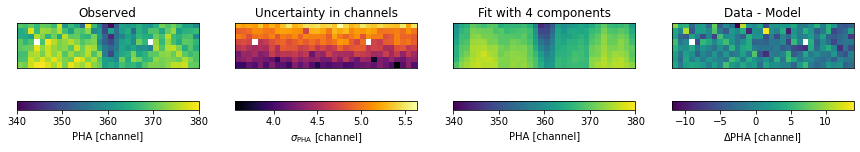

In [52]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 4), subplot_kw={'xticks':[], 'yticks':[]})

# Taking mask from error, because in the data itself, 
# we filled missing values
data = np.ma.array(arr[74, 0, :],
                   mask=np.isnan(err[74, 0, :]))

im = axes[0].imshow(data.reshape((32, 8)).T, 
                    origin='lower', vmin=340, vmax=380)
axes[0].set_title('Observed')
out = plt.colorbar(im, ax=axes[0], orientation='horizontal')
out.set_label('PHA [channel]')

im = axes[1].imshow(err[74, 0, :].reshape((32, 8)).T, 
                    origin='lower', cmap=plt.get_cmap('inferno'))
axes[1].set_title('Uncertainty in channels')
out = plt.colorbar(im, ax=axes[1], orientation='horizontal')
out.set_label('$\sigma_\mathrm{PHA}$ [channel]')

im = axes[2].imshow(top4(x_array).reshape((32, 8)).T, origin='lower', vmin=340, vmax=380)
out = plt.colorbar(im, ax=axes[2], orientation='horizontal')
axes[2].set_title(f'Fit with {n_comp} components')
out.set_label('PHA [channel]')

im = axes[3].imshow((data - top4(x_array)).reshape((32, 8)).T, origin='lower')
out = plt.colorbar(im, ax=axes[3], orientation='horizontal')
axes[3].set_title(f'Data - Model')
out.set_label('$\Delta$PHA [channel]')

This figure shows the observed data for the I3 chip in the Al line in the combined epochs 81 and 82 (left most panel). Note that there are two regions (white) where the signal was too low to determine the peak position at all. The second panel gives the measured uncertainty at each position. The third panel shows the fitted model composed of the top four principal components. Finally, the rightmost panel shows the difference between data and model, this can be compared to the uncertainty in the data.

The difference between data and model has no apparent spatical structure and is fully consistent with noise. There is only a single region (second row in the middle, yellow) that really stands out with a difference of almost 15 channels (about $3\sigma$) between data and model. It is possible that we are looking at a very small scale gain change that is not correlated with the gain changes observed on larger scales (if it was, it would show up in the model as well), but it seems more likely that this is a problem with the data, 
i.e. that there are only few counts to fit the Al emission line in this region in the first place and that the fit did not perform well. We could ask Nick to go back and check...

This example illustrates how PCA can be used for noise reduction. The distribution of the Al line positions (leftmost panel) is clearly noisy on top of some larger scale structure - as it should be, as evidenced by the measured uncertainties. On the other hand, the fitted model is much smoother and noise free.

(Comment: Since the PCA components where derived including all data I have so far, this is techincally not a "statistically independent" test. However, over 225 datasets are input to the PCA and we are using only the top four components, so in practice this is not a problem.)

## How do we know the methods works? What about systematics? What if ACIS changes?

Changing the method to derive the gain and gain calibration after over 20 years in flight should not be done lightly. Fortunately there are good arguments that the method I present here is actually *better* than what we are doing now.

### Does this method introduce new systematics?

The PCA is fundamentally only a different way of looking at the same measurements. It still starts with fitting the peak position of the emission lines observed. If we use the ECS as a data source, each of those fits still has the same systematics it had before. For example, if the position of the Ti line is dodgy because of unresolved line blends, and this introduces a systematic offset in the position of the Ti line peak, then the same systematic offset will also be part of the new basis vectors determined though PCA. So, the PCA does not remove those systematics, but there is also no reason to believe that it introduces new ones. 

### How about solar activity, in particular the upcoming solar maximum?

ACIS has survived two full solar cycles already. As such, components in the dPHA maps that only appear during solar maximum are part of the input data to the PCA. If these components are important to explain the variance of all PHA maps taken, then they will be part of the top few PCA components with a coefficient that is large during a solar maximum and small during a solar minimum. Thus, when the next solar maxium comes up, the fits for these components will simply return a larger coefficient than they currently do.

### What if ACIS changes?
ACIS experienced some sudden changes in the past and these are reflected by sudden jumps in the coefficients of each PCA component as seen in the [explained variance plot for I3](#explained_variance) around 2006. The coefficients for component 3 and 5 suddenly drop close to 0 at this point, but they then the same components rise in importance again in later years (albeit with a different sign for one component) indicating that even in the event of sudden changes the same physical mechanisms are still responsible for gain changes. Of course, past performance over 20 years is no guarantee for future behaviour, but at least a good indication for the typical development. We do not have to rely on this though: Since we perform a $\chi^2$ fit to find the coefficients for new data, we do optain a goodness-of-fit value and can use that to decide if the fit is satisfactory or if additional calibration observations that truely sample the entire chip with high S/N are required. I would recommend to also visually inspect the residuals as in the example above to spot any regions (e.g. one node) that are systematically too high or too low in the model.

## How could this be used in calibration?

In this section, I want to give a short outline how the results above *could* be used to define a calibration plan. Deciding on this is beyond the scope of this document, but I want to give an example of the type of ideas this analysis could be used for.

- Data 2015-2020: Apply this analysis retroactively for data 2015 - 2020. A dPHA map made up from fitting just three components would contain much less noise than the currently used maps.
    - Use smaller tiles with early data and then apply this method from 2015 on?
- New calibrations:
    - Observe Cas A on I0 and I1 once per epoch. Fit coefficients for the top 3 PCA components and make CALDB input from just those three components.
    - For other FI chips, assume that I2 behaves like I0 and all other chips like I1. Get the **change** in coefficients for I0 and I2 and apply the delta for the other chips, e.g. for the scale factor for component one: $s_1^{I2}(epoch 75) = s_1^{I2}(epoch 74) + (s_1^{I0}(epoch 75) - s_1^{I0}(epoch 74))$.
    - Every few epochs: Observe Cas A on every chip.
    - Every few years: Observe Cas A multiple times on I0 and I1 to cover the entire chip and check that the top 3 spatial componenents are still sufficient to describe the distribution.
    
We need to decide how many PCA components we want to use. Three to five seems like a sensible number for the data we are getting today. The early data indicates that there are more physical components, but in the ECS data today the noise already overwhelming those components.

## Notes
Some notes for me or anyone else who might pick up this analysis later again:

- Nick warned me that "The Ti line has the least robust fit of the three due to background and unrelated line blending.". I don't see any evidence here that the Ti line behaves any different from Mn. If one line stands out different, that's Al.
- I tried other spatial decompositions, such as ICA (Independent Component Analysis) and NMF (Non-Negative Matrix Factorization), but results look more noisy and are not as easy to interpert and use. Thus, I refrain from repeating all plots for different schemes.

# Future work

The PCA presetned so far works as shown for one examaple and for Cas A in a separate document. We can start to apply this for new data immidiately to reduce the noise, as a method to fill in gaps where the signal is too low to properly fit the line positions, and to make use of astrophysical data like Cas A that does not fill the detector.

However, I believe we can do even better and thus this analysis continues below. **This is work in progress. Thus, the write-up is less polished and conclusions might still change.** Any comments and ideas are welcome!

The work above is done for three fixed energies and by itself does not allow us to calculate a gain calibration for energies not directly observed. Nick is doing some magic process of smoothing along the columns to reduce noise and fill in data gaps (that should not be necessary any longer) and to interpolate the maps to other energies. 

In what follows, I look for a systematic energy dependence of the coefficients. So far, I have not talked much about the physical relevance of individial PCA components, but [just looking at them](#PCA_components_image) it seems likely that at least some components have physical meaning, e.g. they parameterize the gain difference by node or CTI effects that are more important towards the top of the chip than towards the bottom. In that case, we may expect that these components also have a systematic energy dependance, which can be parameterized in some simple fashion, e.g. the coefficient for component 3 might be linearly correlated with the line energy and coefficient 4 might have an inverse square root dependence. In this section, I try to find such energy dependencies. What could that be used for? First of all, it would remove the extra step that Nick currently does, but more importantly, it would allow us to use crummier data (either with lower signal in each region or with fewer regions with significant signal). For example, in Cas A (see Cas A notebook), we can determine the position of the Fe line only in very few regions and the results have large error bars. If I were to perform the same fit that I did for the ECS Al line in the example above for the Fe line in Cas A, the fit would not be very reliable because only a small part of the chip is sampled at all. If, however, known energy relations provide meaningful constraints, then I could use even a few Fe regions to anchor the fit at higher energies with the Fe lines.

Last, if the dependence on energy is systematic in some form, the same might hold for a temperature dependance and allow us to provide a gain calibration for a warmer or colder focal plane.

### Get errors on the projections coefficients

By definition, the PCA gives exact answers, i.e. the coefficients that it returns project the original vector to the exact position in the new space. However, the input to the PCA is a measured value with a measurement error. Because projection into this new space is a linear process, small perturbances in the measured values will lead to small perturbances in the new space. We can thus determine the uncertainties in the projection coefficients through normal $\chi^2$ statistics. Thus, we get uncertainties on the coefficients that we can use as input to fit an energy or temperature dependence for the coefficients.

I use fitting with Sherpa to get the Covariance matrix. That's more complicated than it has to be, but Sherpa already includes all the scaling, matrix inversion etc, so using that is much simpler for me than coding that up myself.

In [53]:
arr = dat['i3_noTG']['PHA']
err = dat['i3_noTG']['PHA_err']
pca = dat['i3_noTG']['fullpca']
proj = dat['i3_noTG']['fullproj0']
maxn = 5
tind = 50

modelpca=[]
for i in range(maxn):
    comp = TableModel(name=f'comp{i}')
    comp.load(None, pca.components_[i])
    modelpca.append(comp)
top4 = sum(modelpca[1:], modelpca[0])

In [54]:
# make input data masked

# This is really just indexing over regions, but we need to pass in something for x...
x_array = np.arange(256)

locdata = Data1D('locsi', x_array,                    
                 np.ma.array(arr[tind, 0, :], mask=np.isnan(err[tind, 0, :])),
                 staterror=err[tind, 0, :])

for i, m in enumerate(modelpca):
    m.fold(locdata)
    m.ampl = proj[tind, 0, i]

locfit = Fit(locdata, top4, stat=Chi2(), method=NelderMead())
fitres = locfit.fit()

In [55]:
locfit.est_errors()

<covariance results instance>

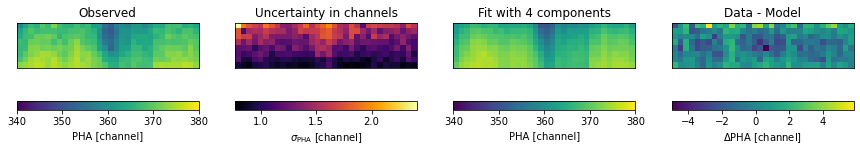

In [56]:
fig, axes = plt.subplots(ncols=4, figsize=(15, 4), subplot_kw={'xticks':[], 'yticks':[]})

# Taking mask from error, because in the data itself, 
# we filled missing values
data = np.ma.array(arr[74, 0, :],
                   mask=np.isnan(err[74, 0, :]))

im = axes[0].imshow(arr[tind, 0, :].reshape((32, 8)).T, 
                    origin='lower', vmin=340, vmax=380)
axes[0].set_title('Observed')
out = plt.colorbar(im, ax=axes[0], orientation='horizontal')
out.set_label('PHA [channel]')

im = axes[1].imshow(err[tind, 0, :].reshape((32, 8)).T, 
                    origin='lower', cmap=plt.get_cmap('inferno'))
axes[1].set_title('Uncertainty in channels')
out = plt.colorbar(im, ax=axes[1], orientation='horizontal')
out.set_label('$\sigma_\mathrm{PHA}$ [channel]')

im = axes[2].imshow(top4(x_array).reshape((32, 8)).T, origin='lower', vmin=340, vmax=380)
out = plt.colorbar(im, ax=axes[2], orientation='horizontal')
axes[2].set_title(f'Fit with {n_comp} components')
out.set_label('PHA [channel]')

im = axes[3].imshow((arr[tind, 0, :] - top4(x_array)).reshape((32, 8)).T, origin='lower')
out = plt.colorbar(im, ax=axes[3], orientation='horizontal')
axes[3].set_title(f'Data - Model')
out.set_label('$\Delta$PHA [channel]')

In [57]:
from sherpa.optmethods import LevMar

def fit_single_tile(modelpca, arr, err, proj=None):
    '''
    Parameters
    ----------
    modelpca : list
        List of `sherpa.models.TableModel` instances
    arr : array
        PHA values for one tile at one energy
    err : array
        uncertainty on PHA value
    proj : array
        Coefficients to initialize model parameters
        
    Returns
    -------
    locfit : `sherpa.fit.FitRes` instance
        Fit results
    '''
    # This is really just indexing over regions, but we need to pass in something for x...
    locdata = Data1D('temp', np.arange(len(arr)),                    
                     np.ma.array(arr, mask=np.isnan(err)),
                     staterror=err)

    for i, m in enumerate(modelpca):
        m.fold(locdata)
        if proj is not None:
            m.ampl = proj[i]

    locfit = Fit(locdata, sum(modelpca[1:], modelpca[0]), stat=Chi2(), method=LevMar())
    return locfit.fit()


def calc_proj_uncert(arr, err, components, maxn=5):
    uncert = np.zeros([*arr.shape[:2], maxn])
    proj = arr @ components.T
    modelpca=[]
    for i in range(maxn):
        comp = TableModel(name=f'comp{i}')
        comp.load(None, components[i])
        modelpca.append(comp)
    
    for tind in range(arr.shape[0]):
        for telem in range(arr.shape[1]):
            fitres = fit_single_tile(modelpca, arr[tind, telem, :], 
                                     err[tind, telem, :], proj[tind, telem, :maxn])    
            uncert[tind, telem, :] = np.diag(np.sqrt(fitres.covar))
    return uncert

In [58]:
arr = dat['i3_noTG']['PHA']
err = dat['i3_noTG']['PHA_err']
components = dat['i3_noTG']['fullpca'].components_

uncert = calc_proj_uncert(arr, err, components, maxn=5)
proj = arr @ components.T
# Will be all 0th by definition so no need to calcualte
# proj0 = np.zeros(arr.shape[-1]) @ components.T

In [59]:
proj_extend = np.zeros((proj.shape[0], proj.shape[1] + 1, proj.shape[2]))
# not needed: All 0 by the way it's set up: proj_extend[:, 0, :] = proj0
proj_extend[:, 1:, :] = proj
line_energies_extend = np.hstack([[0], line_energies])

uncert_extend = np.zeros_like(proj_extend) + 0.001  # a small number, but not 0 to avoid divide by 0 errors
# not needed: All 0 by the way it's set up: proj_extend[:, 0, :] = proj0
uncert_extend[:, 1:, 1:maxn+1] = uncert


## Coefficents over time

This plot shows the ratio of the PCA component scalings for Al/Mn (thick lines) and Ti/Mn (solid, thin lines) for all chips. In many cases, especially for the strongest component (1), the Ti/Mn ratio is constant in time with a value of 0.8 and Al/Mn is constant with a value of 0.5. However, that dependence is far from universal, and even for chips that are "well behaved" most of the time there can be periods where the fits deviate dramatically from that ratio (e.g. 2003 to 2010 for S3). Thus, unless a physical cause for this behaviour is identified, the ratios are not stable enough to be used for predictions.

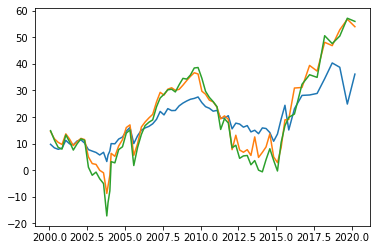

In [60]:
out=plt.plot(epochs['date'].jyear, proj[:, :, 2])

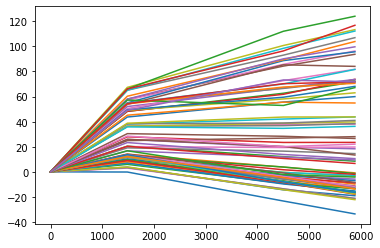

In [61]:
x = np.arange(line_energies_extend.max())
for c in np.arange(-0.02, .01, 0.005):
    pass
    #plt.plot(x, 1.2 * x**.5 + 1 * c  * x, 'k', lw=3)

out = plt.plot(line_energies_extend, proj_extend[:, :, 1].T)


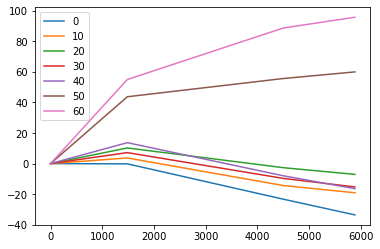

In [62]:
for i in [0, 10, 20, 30, 40, 50, 60]:
    out = plt.plot(line_energies_extend, proj_extend[i, :, 1].T, label=i)
plt.legend()

In [63]:
from sherpa.models.basic import Polynom1D, PowLaw1D
from sherpa.models.model import SimulFitModel
from sherpa.data import DataSimulFit

i_component = 4

ids = range(proj_extend.shape[0])
ids = [0, 15, 20, 30, 40, 50, 60, 70]
sdata = [Data1D(name=i, x=line_energies_extend, y=proj_extend[i, :, i_component],
                 staterror=uncert_extend[i, :, i_component]) for i in ids]
sdall = DataSimulFit('all', sdata)

spoly = [Polynom1D(name=f'l{i}') for i in ids]
spow = [PowLaw1D(name=f'p{i}') for i in ids]
smod = [a + b for a, b in zip(spoly, spow)]
small = SimulFitModel('all', smod)

In [64]:
# Setting for polynom
for p in spoly:
    p.c0.frozen = True
    p.c1.frozen = False
    p.c2.frozen = True
    p.c1 = -.01
    p.c2 = 0.

for p in spoly[1:]:
    p.c1 = spoly[0].c1
    #p.c1.link=None 

spoly[0].c1.frozen=False
    
    
# Settings for powerlaw
for p in spow:
    p.gamma = -0.5
    
for p in spow[1:]:
    
    p.gamma = spow[0].gamma
    #p.gamma.link = None
    p.ampl = spow[0].ampl
    p.ampl.link = None

    
spow[0].gamma = -0.5
spow[0].gamma.frozen = False

spow[0].ampl.min = -10  # Default is 0
spow[0].ampl = 1
spow[0].ampl.frozen = False

In [65]:
f = Fit(sdall, small, stat=Chi2(), method=NelderMead())
f.fit()

<Fit results instance>

## Can we find functional dependence on energy?

Text(0.5, 0, 'energy [eV]')

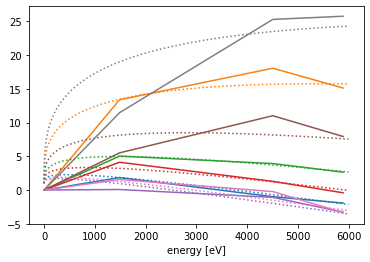

In [66]:
x = np.arange(6000)

for d, m in zip(sdata, smod):
    out = plt.plot(d.x, d.y)
    plt.plot(x, m(x), ':', c=out[0].get_color())

plt.xlabel('energy [eV]')

#### Citations
(Just collecting sone information here so I don't forget about it when we turn this into an SPIE paper or something similar.)

scikit learn: https://scikit-learn.org/stable/about.html#citing-scikit-learn